In [1]:
import Rible as RB
include(joinpath(pathof(RB),"../../test/yard/nonsmooth/deps.jl"))
include(joinpath(pathof(RB),"../../test/vis.jl"))
scalefactor = 4

include( joinpath(pathof(RB),"../../examples/bodies/hammer.jl"))
include( joinpath(pathof(RB),"../../examples/bodies/cable_ancf.jl"))
include( joinpath(pathof(RB),"../../examples/robots/meteor_hammer.jl"))

make_meteor_hammer (generic function with 1 method)

## Second Scenario

set up the inclined plane

In [2]:
R = RotXY(deg2rad(0),deg2rad(-0))
inclined_plane = RB.Plane(R*[0,0,1.0],[-1.039230,-0.0,0.781])
p1 =  [-1.039230,0,0.780]
p2 = [-1.173952,-0.11,0.8646278]
p3 = [-0.901447,-0.112500,0.762216]
n = (p2-p1) × (p3 - p1 )
inclined_plane = RB.Plane(n,p3.+[0,0,0.001])
inclined_plane_env = RB.StaticContactSurfaces(
    [
        inclined_plane
    ]
)

Rible.StaticContactSurfaces{Vector{Rible.Plane{Float64, 3}}}(Rible.Plane{Float64, 3}[Rible.Plane{Float64, 3}([0.34045555677679606, 0.27482310220275524, 0.8992009098946997], -0.3484642823586107, [-0.901447, -0.1125, 0.763216])])

use dynamic relax to find a static equilibrium, fixing two ends of the cable.

In [3]:
meteor_hammer_DR = make_meteor_hammer(;
        ri  = [ 0.0, 0.0, 1.5],
        rix = [ 0.0, 0.0,-1.0],
        rj  = [-0.6*√3, 0.0, 1.2],
        rjx = [ 0.0,-1.0, 0.0],
        L=1.2,nx=5,doDR=true
)
RB.GDR!(meteor_hammer_DR;β=1e-3,maxiters=2e5,damper=Val(:drift),c=0.9,d=10,verbose=false);

(ρ, E) = (1030.0, 2.0e8)
mass = 0.015532034079347936
(m, diag(Īg), mass_locus, length(loci), friction_coefficients, restitution_coefficients) = (4.58794901, [0.00522676, 0.00512073, 0.00512073], [-0.2, 0.0, 0.0], 14, [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])


set the initial conditions

In [4]:
meteor_hammer = make_meteor_hammer(;
    ri  = [ 0.0, 0.0, 1.5],
    rix = [ 0.0, 0.0,-1.0],
    rj  = [-0.6*√3, 0.0, 1.2],
    rjx = [ 0.0,-1.0, 0.0],
    e = 0.0,
    μ=0.1,L=1.2,nx=5,R=RotY(-π/2),
    ω=-200n,
)
meteor_hammer_DR.traj.q[end][end-8:end] .= meteor_hammer.traj.q[end][end-8:end]
meteor_hammer_DR.traj.q̇[end][end-8:end] .= meteor_hammer.traj.q̇[end][end-8:end]
RB.set_new_initial!(meteor_hammer,meteor_hammer_DR.traj.q[end],meteor_hammer_DR.traj.q̇[end])

(ρ, E) = (1030.0, 2.0e8)
mass = 0.015532034079347936
(m, diag(Īg), mass_locus, length(loci), friction_coefficients, restitution_coefficients) = (4.58794901, [0.00522676, 0.00512073, 0.00512073], [-0.2, 0.0, 0.0], 14, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


1-element StructArray(::Vector{Float64}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}) with eltype Rible.NonminimalCoordinatesState{Float64, Vector{Float64}, SubArray{Float64, 1, Vector{Float64}, Tuple{Vector{Int64}}, false}, Vector{Float64}}:
 Rible.NonminimalCoordinatesState{Float6

sliding and avg err

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
[ Info: Saving to meteor_sliding.png


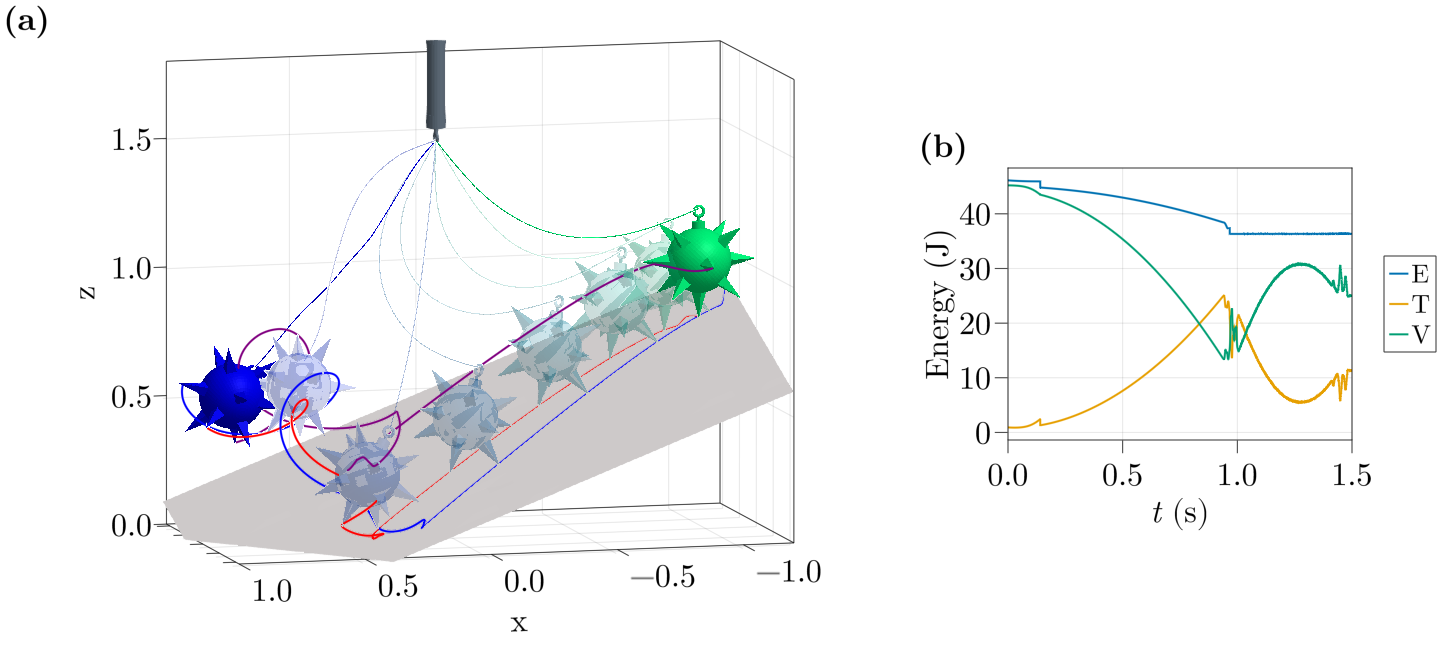

In [5]:
tspan = (0.0,1.5)
h = 2e-4

RB.solve!(
    RB.DynamicsProblem(
        meteor_hammer,
        inclined_plane_env,
        RB.RestitutionFrictionCombined(
            RB.NewtonRestitution(),
            RB.CoulombFriction(),
        )
    ),
    RB.DynamicsSolver(
        RB.Zhong06(),
        RB.InnerLayerContactSolver(
            RB.InteriorPointMethod()
        ),
    );
    tspan,dt=h,ftol=1e-14,maxiters=50,exception=false,verbose=false
)


me = RB.mechanical_energy!(meteor_hammer)

GM.activate!(;scalefactor);with_theme(theme_pub;
        size = (0.8tw,0.36tw),
        figure_padding = (fontsize,1.5fontsize,0,0),
        Axis3=(
            azimuth = 7.595530633326987,
            elevation = 0.14269908169872403
        )
    ) do
    bot = meteor_hammer
    (;t) = bot.traj
    rp1 = RB.get_trajectory!(bot,6,1)
    rp12 = RB.get_trajectory!(bot,6,12)
    rp10 = RB.get_trajectory!(bot,6,10)
    fig = Figure()
    gd1 = fig[1,1] = GridLayout()
    gd2 = fig[1,2] = GridLayout(;tellheight=false)
    steps = 1:1000:length(bot.traj)
    laststep = last(steps)
    cg = cgrad(:winter, length(steps), categorical = true, rev = true)
    nstep = length(steps)
    alphas = fill(0.2,nstep)
    alphas[1:3] = [1, 0.2, 0.2]
    alphas[end] = 1
    plot_traj!(
        bot;
        AxisType=Axis3,
        fig = gd1,
        showtitle=false,
        showpoints=false,
        showlabels=false,
        showarrows=false,
        showcables=false,
        showwire=false,
        showmesh=false,
        xlims=(-1.2,1.0),
        ylims=(-0.3,0.8),
        zlims=(-0.0,1.8),
        doslide=false,
        showinfo=false,
        ground=inclined_plane,
        sup! = (ax,_,_) -> begin
            for (i,step) in enumerate(steps)
                RB.goto_step!(bot,step)
                tgvis = deepcopy(bot.structure)
                (;r,g,b) = cg[i]
                RB.viz!(ax,tgvis;
                    meshcolor=Makie.RGBAf(r,g,b,alphas[i])
                )
            end
            lines!(ax,rp1[begin:laststep],color=:red)
            lines!(ax,rp12[begin:laststep],color=:blue)
            lines!(ax,rp10[begin:laststep],color=:purple)
            handlemesh = load(joinpath(RB.assetpath(),"把柄.STL")) |> RB.make_patch(;
                scale = 1/400,
                trans = [ 0.0, 0.0, 1.55],
                rot = RotY(-π/2)
            )
            RB.hidey(ax)
            mesh!(ax,handlemesh)
        end
    )
    ax2 = Axis(gd2[1,1],
        xlabel = tlabel,
        ylabel = "Energy (J)",
    )
    lines!(ax2,t,me.E,label="E")
    lines!(ax2,t,me.T,label="T")
    lines!(ax2,t,me.V,label="V")
    xlims!(ax2,extrema(t)...)
    Legend(gd2[1,2],ax2)
    colsize!(fig.layout,1,0.45tw)
    rowgap!(fig.layout,0)
    Label(
        gd1[1,1,TopLeft()],"($(alphabet[1]))",font = :bold,
    )
    Label(
        gd2[1,1,TopLeft()],"($(alphabet[2]))",font = :bold
    )
    colsize!(fig.layout,2,Relative(0.36))
    rowsize!(gd2,1,0.15tw)
    colgap!(fig.layout,-fontsize)
    savefig(fig,"meteor_sliding")
    fig
end

Convergence analysis

Progress: 100%|█████████████████████████████████████████| Time: 0:01:48
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00
[ Info: Saving to meteor_hammer_convergence.pdf


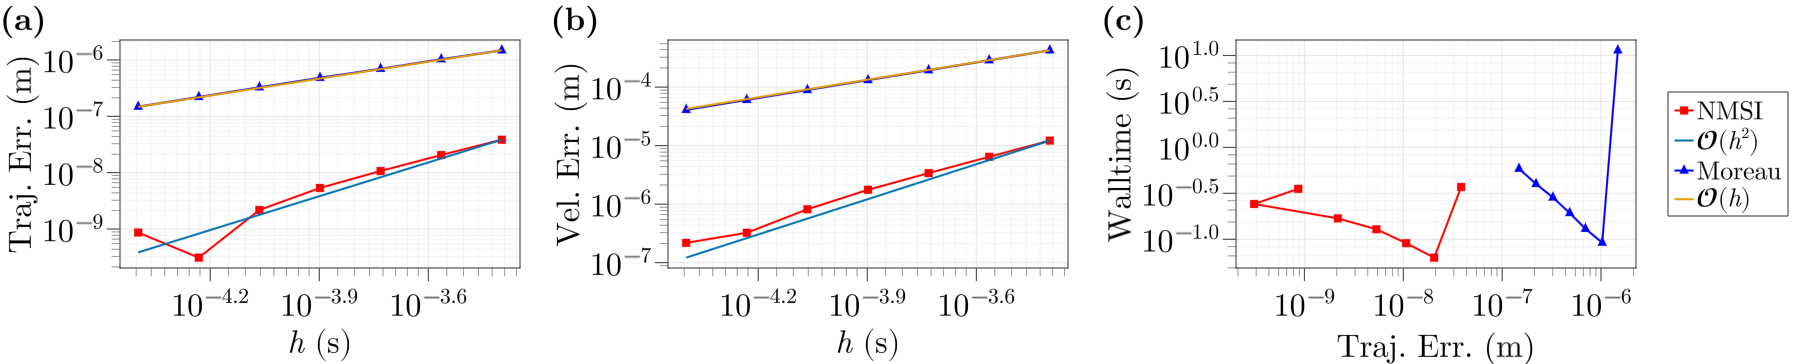

In [6]:
dts = vcat([4*10^(-s) for s in range(4,5;length=7)],2e-7)
stats_meteor_hammers_dt = [
    begin
        meteor_hammer_dt = deepcopy(meteor_hammer)
        @timed RB.solve!(
            RB.DynamicsProblem(
                meteor_hammer_dt,
                inclined_plane_env,
                RB.RestitutionFrictionCombined(
                    RB.NewtonRestitution(),
                    RB.CoulombFriction(),
                )
            ),
            RB.DynamicsSolver(
                solver,
                RB.InnerLayerContactSolver(
                    RB.InteriorPointMethod()
                ),
            );
            tspan=(0.0,0.01),dt,ftol=1e-14,max_restart=3
        ).prob.bot
    end
    for dt in dts, solver = (
        RB.Zhong06(),
        RB.Moreau(0.5),
    )
]
meteor_hammers_dt = map((x)->x.value,stats_meteor_hammers_dt);

GM.activate!(;scalefactor);with_theme(theme_pub;
        size = (1tw,0.2tw),
    ) do
    fig = Figure()
    ax1 = Axis(fig[1,1];ylabel="Traj. Err. (m)")
    ax2 = Axis(fig[1,2];ylabel="Vel. Err. (m)")
    ax3 = Axis(fig[1,3];xlabel="Traj. Err. (m)", ylabel="Walltime (s)")
    _, traj_nmsi = RB.get_err_avg(vcat(meteor_hammers_dt[begin:end-1,1],meteor_hammers_dt[end,2]);bid=6,pid=10,di=1)
    _, vel_nmsi = RB.get_err_avg(vcat(meteor_hammers_dt[begin:end-1,1],meteor_hammers_dt[end,2]);bid=6,pid=10,di=1,field=:midvel)
    _, traj_moreau = RB.get_err_avg(meteor_hammers_dt[:,2];bid=6,pid=10,di=1)
    _, vel_moreau = RB.get_err_avg(meteor_hammers_dt[:,2];bid=6,pid=10,di=1,field=:midvel)
    plot_convergence_order!(ax1,dts[begin:end-1],traj_nmsi;orders=[2])
    plot_convergence_order!(ax1,dts[begin:end-1],traj_moreau;label="Moreau",marker=:utriangle,color=:blue,orders=[1])
    plot_convergence_order!(ax2,dts[begin:end-1],vel_nmsi;orders=[2])
    plot_convergence_order!(ax2,dts[begin:end-1],vel_moreau;label="Moreau",marker=:utriangle,color=:blue,orders=[1])
    moreau_time = map((x)->x.time-x.gctime,stats_meteor_hammers_dt[begin:end-1,2])
    nmsi_time = map((x)->x.time-x.gctime,stats_meteor_hammers_dt[begin:end-1,1])
    scatterlines!(ax3,traj_moreau,moreau_time;marker=:utriangle,color=:blue,)
    scatterlines!(ax3,traj_nmsi,nmsi_time;marker=:rect,color=:red)
    ax3.xscale = Makie.log10
    ax3.xminorticksvisible = true
    ax3.xminorgridvisible = true
    ax3.xminorticks = IntervalsBetween(8)
    ax3.yscale = Makie.log10
    ax3.yminorticksvisible = true
    ax3.yminorgridvisible = true
    ax3.yminorticks = IntervalsBetween(4)
    Legend(fig[1,4],ax1)
    Label(fig[1,1,TopLeft()],"($(alphabet[1]))",font = :bold)
    Label(fig[1,2,TopLeft()],"($(alphabet[2]))",font = :bold)
    Label(fig[1,3,TopLeft()],"($(alphabet[3]))",font = :bold)
    savefig(fig,"meteor_hammer_convergence";backend=CM)
    fig
end

## First Scenario

(ρ, E) = (1030.0, 2.0e8)
mass = 0.015532034079347936
(m, diag(Īg), mass_locus, length(loci), friction_coefficients, restitution_coefficients) = (4.58794901, [0.00522676, 0.00512073, 0.00512073], [-0.2, 0.0, 0.0], 14, [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])
(ρ, E) = (1030.0, 2.0e8)
mass = 0.015532034079347936
(m, diag(Īg), mass_locus, length(loci), friction_coefficients, restitution_coefficients) = (4.58794901, [0.00522676, 0.00512073, 0.00512073], [-0.2, 0.0, 0.0], 14, [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
step_before_impact = 2992
(vminus, vplus, vplus / -vminus) = (-4.487626006205297, 2.24381300316082, 0.5000000000129626)
[ Info: Saving to meteor_swing.png


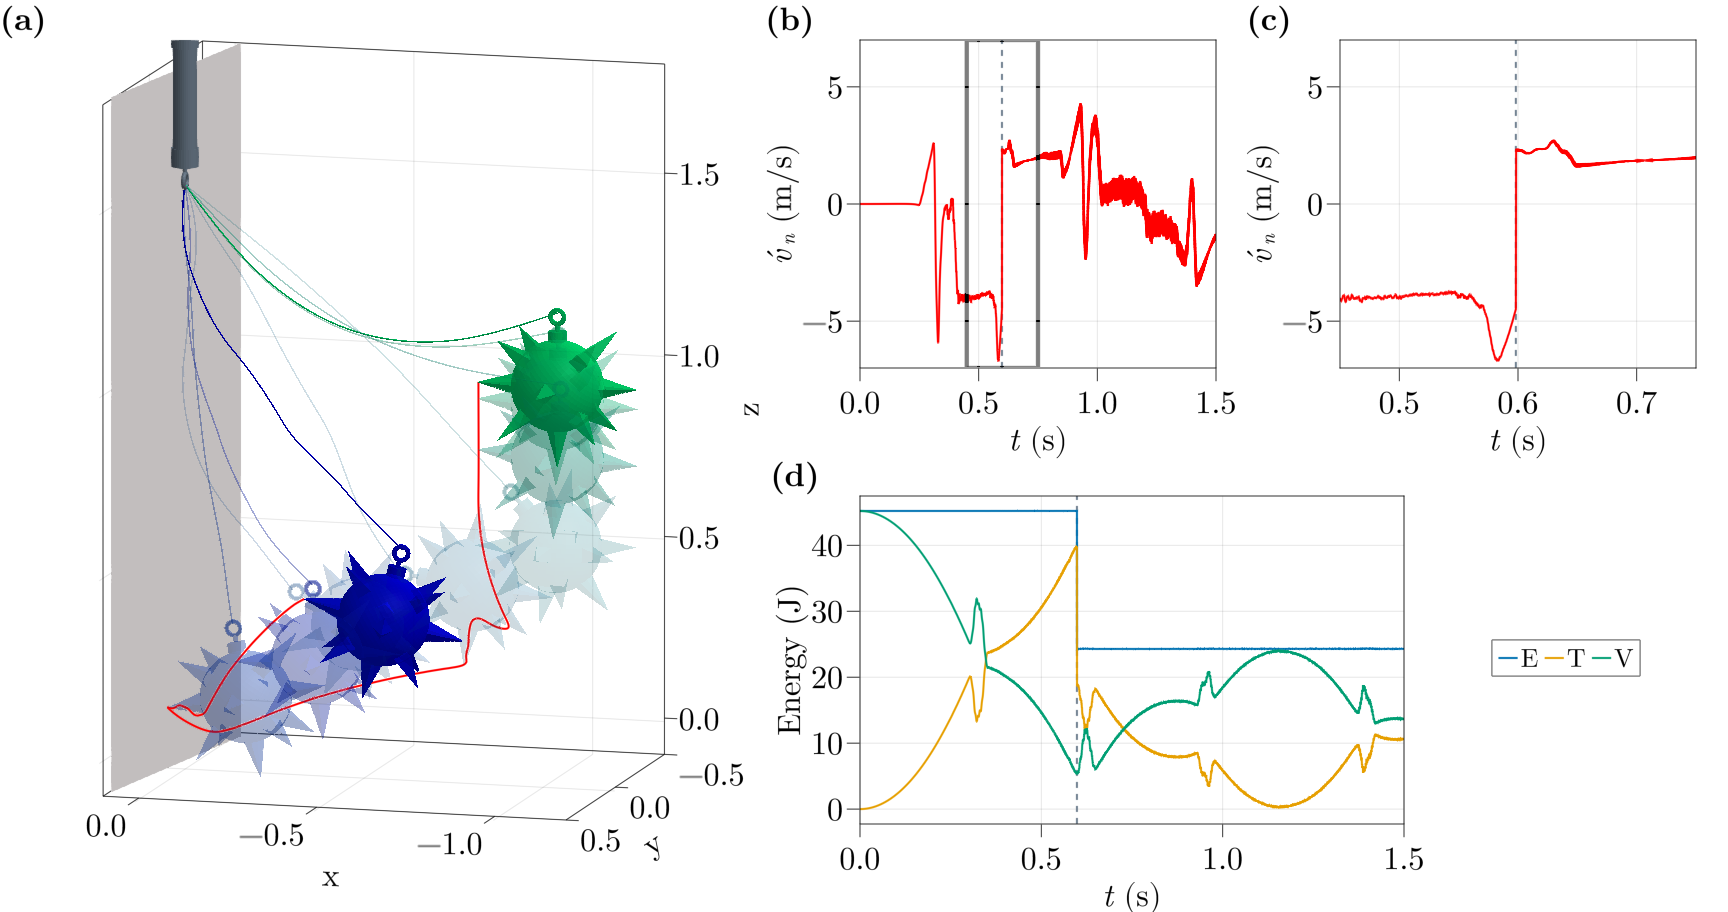

In [7]:
meteor_hammer_DR = make_meteor_hammer(;
        ri  = [ 0.0, 0.0, 1.5],
        rix = [ 0.0, 0.0,-1.0],
        rj  = [-0.6*√3, 0.0, 1.2],
        rjx = [ 0.0,-1.0, 0.0],
        L=1.2,nx=5,doDR=true
)
RB.GDR!(meteor_hammer_DR;β=1e-3,maxiters=2e5,damper=Val(:drift),c=0.9,d=10,verbose=false);
meteor_hammer = make_meteor_hammer(;
    ri  = [ 0.0, 0.0, 1.5],
    rix = [ 0.0, 0.0,-1.0],
    rj  = [-0.6*√3, 0.0, 1.2],
    rjx = [ 0.0,-1.0, 0.0],
    e = 0.5,
    μ = 0.9,
    L=1.2,nx=5,R=RotY(-π/2)
)
RB.set_new_initial!(meteor_hammer,meteor_hammer_DR.traj.q[end],meteor_hammer_DR.traj.q̇[end])

plane_normal = RotZY(deg2rad(-7.5),deg2rad(-90))*[0,0,1.0]
inclined_plane = RB.Plane(plane_normal,[0.05,0,0])

inclined_plane_env = RB.StaticContactSurfaces(
    [
        inclined_plane
    ]
)


h = 2e-4
tspan = (0.0,1.5)
RB.solve!(
    RB.DynamicsProblem(
        meteor_hammer,
        inclined_plane_env,
        RB.RestitutionFrictionCombined(
            RB.NewtonRestitution(),
            RB.CoulombFriction(),
        )
    ),
    RB.DynamicsSolver(
        RB.Zhong06(),
        RB.InnerLayerContactSolver(
            RB.InteriorPointMethod()
        ),
    );
    tspan,dt=h,ftol=1e-14,maxiters=50,exception=false,verbose=false
)

me = RB.mechanical_energy!(meteor_hammer)
lines(meteor_hammer.traj.t,(me.E.-me.E[begin])./me.E[begin])
rp2 = RB.get_trajectory!(meteor_hammer,6,2)
vp2 = RB.get_velocity!(meteor_hammer,6,2)
pnvp2 = [plane_normal'*v for v in vp2 ];

GM.activate!(;scalefactor);with_theme(theme_pub;
        size = (0.95tw,0.5tw),
        figure_padding = (0,fontsize,0,0),
        Axis3=(
            azimuth = 8.125530633326981,
            elevation = 0.18269908169872404
        ),
        Poly=(
            transparency=true,
        )
    ) do
    bot = meteor_hammer
    (;t) = bot.traj
    fig = Figure()
    gd2 = fig[1,2] = GridLayout()
    gd3 = fig[2,2] = GridLayout()
    gd1 = fig[:,1] = GridLayout()
    steps = 1:500:4001
    alphas = [1, 0.2, 0.2, 0.1, 0.1, 0.1, 0.2, 0.2, 1]
    cg = cgrad(:winter, length(steps), categorical = true, rev = true)
    plot_traj!(
        bot;
        AxisType=Axis3,
        fig = gd1,
        showtitle=false,
        showpoints=false,
        showlabels=false,
        showarrows=false,
        showcables=false,
        showmesh=false,
        showwire=false,
        xlims=(-1.2,0.1),
        ylims=(-0.5,0.5),
        zlims=(-0.1,1.8),
        doslide=false,
        showinfo=false,
        ground=inclined_plane,
        sup! = (ax,_,_) -> begin
            for (i,step) in enumerate(steps)
                RB.goto_step!(bot,step)
                tgvis = deepcopy(bot.structure)
                (;r,g,b) = cg[i]
                RB.viz!(ax,tgvis;meshcolor=Makie.RGBA(r,g,b,alphas[i]))
            end
            lines!(ax,rp2[:,begin:4001],color=:red)
            handlemesh = load(joinpath(RB.assetpath(),"把柄.STL")) |> RB.make_patch(;
                scale = 1/400,
                trans = [ 0.0, 0.0, 1.55],
                rot = RotY(-π/2)
            )
            mesh!(ax,handlemesh)
        end
    )
    ax2 = Axis(gd2[1,1],
        xlabel = tlabel,
        ylabel = L"\acute{v}_n~(\mathrm{m/s})",
    )
    impact_time = 2991*h
    step_before_impact = RB.time2step(impact_time,t)
    @myshow step_before_impact
    vminus, vplus = pnvp2[step_before_impact:step_before_impact+1]
    @myshow vminus, vplus, vplus/(-vminus)
    vlines!(ax2,[impact_time];linestyle=:dash)
    lines!(ax2,t,pnvp2,color=:red)
    ylims!(ax2,-7,7)
    xlims!(ax2,extrema(t)...)
    poly!(ax2,Point2f.([[0.45,-7],[0.45,7],[0.75,7],[0.75,-7]]),
        color=Makie.RGBAf(0,0,0,0),
        strokecolor=:black,
        strokewidth=1,
        )
    ax22 = Axis(gd2[1,2],
        xlabel = tlabel,
        ylabel = L"\acute{v}_n~(\mathrm{m/s})",
    )
    vlines!(ax22,[impact_time];linestyle=:dash)
    lines!(ax22,t,pnvp2,color=:red)
    ylims!(ax22,-7,7)
    xlims!(ax22,0.45,0.75)
    ax3 = Axis(gd3[1,1],
        xlabel = tlabel,
        ylabel = "Energy (J)"
    )
    vlines!(ax3,[impact_time];linestyle=:dash)
    lines!(ax3,t,me.E,label="E")
    lines!(ax3,t,me.T,label="T")
    lines!(ax3,t,me.V,label="V")
    Legend(gd3[1,2],ax3,orientation=:horizontal,tellheight=false)
    xlims!(ax3,extrema(t)...)
    Label(
        gd1[1,1,TopLeft()],"($(alphabet[1]))",font = :bold,
    )
    Label(
        gd2[1,1,TopLeft()],"($(alphabet[2]))",font = :bold
    )
    Label(
        gd2[1,2,TopLeft()],"($(alphabet[3]))",font = :bold
    )
    Label(
        gd3[1,1,TopLeft()],"($(alphabet[4]))",font = :bold
    )
    colsize!(fig.layout,1,0.35tw)
    colsize!(gd3,1,0.3tw)
    rowgap!(fig.layout,0)
    colgap!(fig.layout,0)
    savefig(fig,"meteor_swing")
    fig
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*